In [1]:
import numpy as np
import torch
import pickle
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
path = r"Y:\Datasets\Fyzio"
exercise = "Wide squat"


In [3]:
with open(os.path.join(path,"X_train",exercise + ".pkl"),"rb") as f:
    x = np.array(pickle.load(f))
    print(x.shape)

(20551, 200, 20)


In [4]:
with open(os.path.join(path,"Y_train",exercise + ".pkl"),"rb") as f:
    y = np.array(pickle.load(f))
    print(y.shape)


(20551, 1)


In [5]:

x_norm = np.zeros_like(x)
means = []
stds = []
print(x.shape)
for ch in range(x.shape[2]):
    mean = x[:, :, ch].mean()
    std = x[:, :, ch].std()
    x_norm[:, :, ch] = (x[:, :, ch] - mean) / std
    means.append(mean)
    stds.append(std)

# y_min = y.min(axis=0, keepdims=True)
# y_max = y.max(axis=0, keepdims=True)
# y_norm = (y - y_min) / (y_max - y_min)
y_norm = y/100

(20551, 200, 20)


In [6]:
y_norm_t = torch.from_numpy(y_norm).float()[:,0]

x_norm_t = torch.from_numpy(x_norm).float()
x_norm_t = x_norm_t.permute(0,2,1)
x_train,x_test,y_train,y_test = train_test_split(x_norm_t,y_norm_t,test_size=0.3,random_state=42)
print(y_train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

tensor([0.8793, 0.5044, 0.0193,  ..., 0.8471, 0.7234, 0.6378])
cuda
2.7.1+cu128
12.8
90701


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cnn1 = 64
cnn2 = 128
cnn3 = 128
class Net(nn.Module):
    def __init__(self, in_channels,seq_len):
        super(Net,self).__init__()
        self.cnn1 = nn.Conv1d(in_channels, cnn1, kernel_size=3, padding=1)
        self.normalization1=nn.BatchNorm1d(cnn1)
        self.pool1= nn.MaxPool1d(2)
        self.cnn2 = nn.Conv1d(cnn1, cnn2, kernel_size=3, padding=1)
        self.normalization2=nn.BatchNorm1d(cnn2)
        self.pool2= nn.MaxPool1d(2)
        self.cnn3 = nn.Conv1d(cnn2, cnn3, kernel_size=3, padding=1)
        self.normalization3=nn.BatchNorm1d(cnn3)
        self.pool3= nn.MaxPool1d(2)
        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, seq_len)
            out = self.pool1(F.relu(self.cnn1(dummy)))
            out = self.pool2(F.relu(self.cnn2(out)))
            out = self.pool3(F.relu(self.cnn3(out)))
            flat_dim = out.view(1, -1).size(1)


        self.snn1 = nn.Linear(flat_dim, 64)
        self.dropout1 = nn.Dropout(p=0.5)
        self.snn2 = nn.Linear(64, 8)
        self.dropout2 = nn.Dropout(p=0.3)
        self.snn3 = nn.Linear(8, 2)

    def forward(self, x):
        x = self.cnn1(x)
        x = F.relu(x)
        x = self.normalization1(x)
        x = self.pool1(x)
        x = self.cnn2(x)
        x = F.relu(x)
        x = self.normalization2(x)
        x = self.pool2(x)
        x = self.cnn3(x)
        x = F.relu(x)
        x = self.normalization3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.snn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.snn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        out = self.snn3(x)
        return out



def circ_signed_diff(y_true, y_pred, period=1.0):
    """
    Nejkratší rozdíl na kružnici v rozsahu [-period/2, period/2].
    Očekává tensory stejného tvaru.
    """
    diff = y_pred - y_true
    return (diff + period/2) % period - period/2

class CircularMSELoss(nn.Module):
    def __init__(self, period=1.0, reduction='mean'):
        super().__init__()
        self.period = period
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        d = circ_signed_diff(y_true, y_pred, self.period)
        loss = d ** 2
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# in_channels = x_train.shape[1]
# seq_len = x_train.shape[2]
#
# out_features = 1
#
# net = Net(in_channels,seq_len).to(device)
# params = list(net.parameters())
# print(len(params))
# print(params[0].size())


In [8]:
# from torch.utils.data import TensorDataset, DataLoader
#
# train_dataset = TensorDataset(x_train, y_train)
# val_dataset = TensorDataset(x_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [22]:
def add_noise(x, noise_factor=0.001):
    return x + noise_factor * torch.randn_like(x)

def time_shift(x, shift_max=10):
    shift = int(torch.randint(-shift_max, shift_max+1, (1,)))
    return torch.roll(x, shifts=shift)

def scale(x, factor_range=(0.9, 1.1)):
    factor = torch.empty(1).uniform_(*factor_range)
    return x * factor

def drop(x):
    x = x.clone()
    n_channels = x.shape[0]
    ch = torch.randint(0, n_channels,(1,)).item()
    x[ch, :] = 0.0
    return x

def random_augment(x):
    if torch.rand(1) < 0.4:
        x = add_noise(x)
    if torch.rand(1) < 0.3:
        x = time_shift(x)
    if torch.rand(1) < 0.2:
        x = scale(x)
    if torch.rand(1) < 0.3:
        x = drop(x)
    return x


In [23]:
from torch.utils.data import Dataset

class AugmentedSignalDataset(Dataset):
    def __init__(self, X, Y, augment=True):
        self.X = X
        self.Y = Y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.augment:
            x = random_augment(x)
        y_vec = torch.tensor([torch.sin(2 * np.pi * y), torch.cos(2 * np.pi * y)], dtype=torch.float32)
        return x, y_vec


In [24]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = x_norm_t.cpu().numpy()
Y = y_norm_t.cpu().numpy()

in_channels = x_train.shape[1]
seq_len = x_train.shape[2]
epochs = 100
batch_size = 32
nets = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")

    X_train, X_val = X[train_idx], X[val_idx]
    Y_train, Y_val = Y[train_idx], Y[val_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).view(-1, 1)

    train_dataset = AugmentedSignalDataset(X_train_tensor, Y_train_tensor,augment=True)
    val_dataset = AugmentedSignalDataset(X_val_tensor, Y_val_tensor,augment=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    net = Net(in_channels, seq_len).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    # criterion = CircularMSELoss()
    criterion = nn.MSELoss()
    # criterion = nn.L1Loss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    for epoch in range(epochs):
        net.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)


        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                val_outputs = net(batch_X)
                loss = criterion(val_outputs, batch_y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    net.eval()
    with torch.no_grad():
        outputs = net(X_val_tensor.to(device))
        outputs_np = outputs.cpu().numpy()
        pred_phase = np.arctan2(outputs_np[:,0], outputs_np[:,1]) / (2*np.pi)
        pred_phase = (pred_phase + 1) % 1.0

        y_true = Y_val_tensor.cpu().numpy().flatten()

    mse = mean_squared_error(y_true, pred_phase)
    r2 = r2_score(y_true, pred_phase)
    print(f"Fold {fold+1} - MSE: {mse:.4f}, R²: {r2:.4f}\n")

    fold_results.append((y_true, pred_phase))
    nets.append(net)


mse_l = []
r2_l = []

for y_true, preds in fold_results:
    mse_l.append(mean_squared_error(y_true, preds))
    r2_l.append(r2_score(y_true, preds))

print(np.mean(mse_l))
print(np.mean(r2_l))

Fold 1
Epoch 10/100, Train Loss: 0.1321, Val Loss: 0.0400
Epoch 20/100, Train Loss: 0.1116, Val Loss: 0.0338
Epoch 30/100, Train Loss: 0.1057, Val Loss: 0.0301
Epoch 40/100, Train Loss: 0.1018, Val Loss: 0.0204
Epoch 50/100, Train Loss: 0.0979, Val Loss: 0.0208
Epoch 60/100, Train Loss: 0.0967, Val Loss: 0.0184
Epoch 70/100, Train Loss: 0.0967, Val Loss: 0.0192
Epoch 80/100, Train Loss: 0.0967, Val Loss: 0.0191
Epoch 90/100, Train Loss: 0.0963, Val Loss: 0.0191
Epoch 100/100, Train Loss: 0.0977, Val Loss: 0.0190
Fold 1 - MSE: 0.0112, R²: 0.8641

Fold 2
Epoch 10/100, Train Loss: 0.1393, Val Loss: 0.0515
Epoch 20/100, Train Loss: 0.1130, Val Loss: 0.0290
Epoch 30/100, Train Loss: 0.1051, Val Loss: 0.0249
Epoch 40/100, Train Loss: 0.1023, Val Loss: 0.0226
Epoch 50/100, Train Loss: 0.0991, Val Loss: 0.0197
Epoch 60/100, Train Loss: 0.0958, Val Loss: 0.0226
Epoch 70/100, Train Loss: 0.0973, Val Loss: 0.0192
Epoch 80/100, Train Loss: 0.0970, Val Loss: 0.0194
Epoch 90/100, Train Loss: 0.0946,

In [11]:
#Training

# import torch.optim as optim
# from sklearn.model_selection import KFold
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=5e-4)
#
#
# epochs = 100
# for epoch in range(epochs):
#     net.train()
#     train_loss = 0.0
#     for batch_X, batch_y in train_loader:
#         batch_X = batch_X.to(device)
#         batch_y = batch_y.to(device).float().unsqueeze(1)
#
#         optimizer.zero_grad()
#         outputs = net(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
#
#         train_loss += loss.item()
#
#     train_loss /= len(train_loader)
#
#     net.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for batch_X, batch_y in val_loader:
#             batch_X = batch_X.to(device)
#             batch_y = batch_y.to(device).float().unsqueeze(1)
#             val_outputs = net(batch_X)
#             loss = criterion(val_outputs, batch_y)
#             val_loss += loss.item()
#
#     val_loss /= len(val_loader)
#
#     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n")


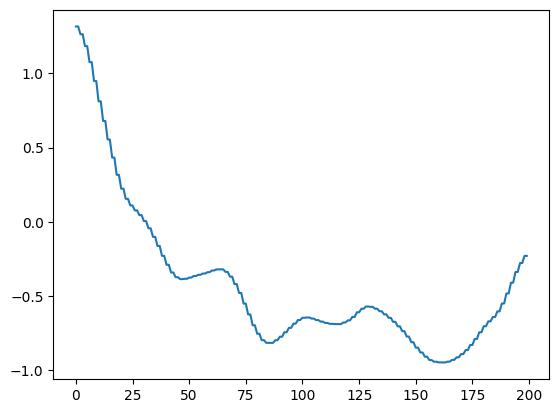

In [26]:
import matplotlib.pyplot as plt
plt.plot(x_train[10][4])
plt.show()

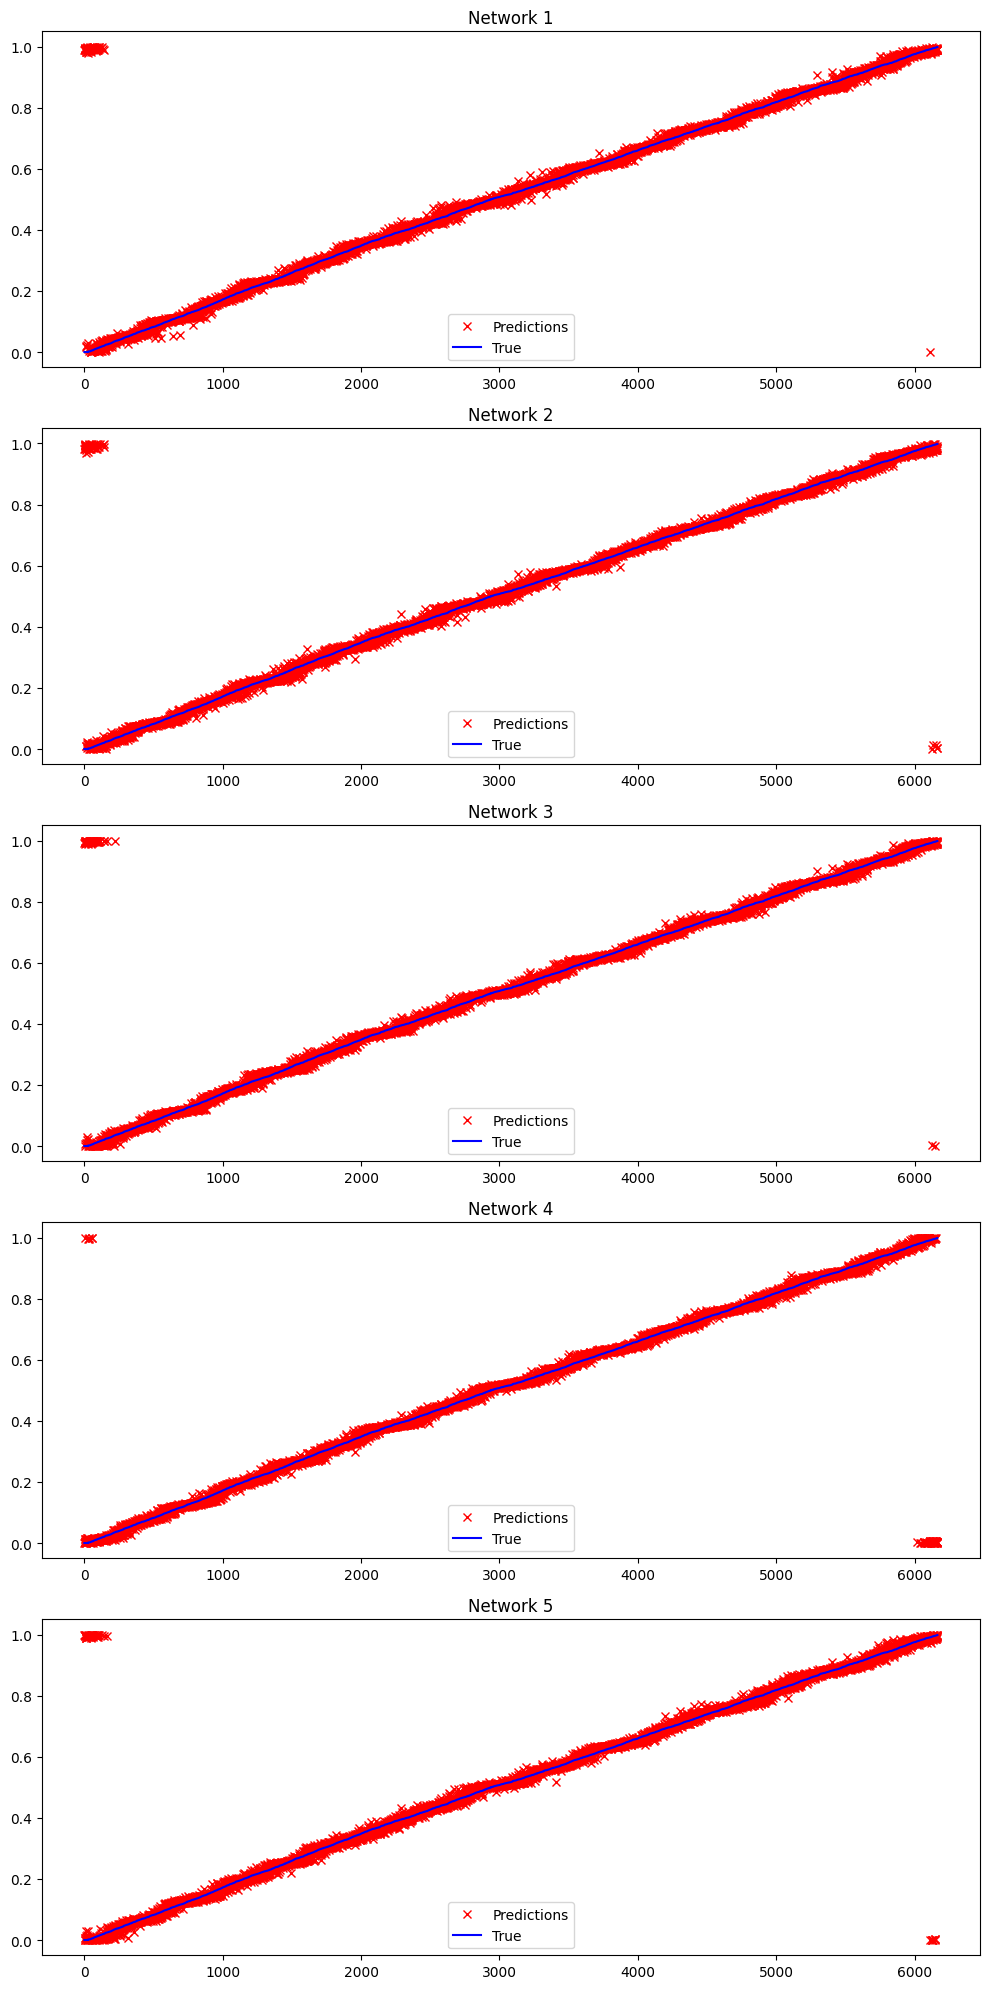

In [27]:
sorted_indices = np.argsort(y_test)

y_test_sorted = y_test[sorted_indices]
x_test_sorted = x_test[sorted_indices]

outputs = []
with torch.no_grad():
    for net in nets:
        outputs.append(net(x_test_sorted.to(device)))

preds_list = [out.cpu().numpy() for out in outputs]
predictions = []

for i in preds_list:
    pred_phase = np.arctan2(i[:,0], i[:,1]) / (2*np.pi)
    pred_phase = (pred_phase + 1) % 1.0
    predictions.append(pred_phase)

fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, ax in enumerate(axes):
    ax.plot(predictions[i], 'rx', linestyle='None', label="Predictions")
    ax.plot(y_test_sorted, color="blue", label="True")
    ax.set_title(f'Network {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()


In [28]:
for index,net in enumerate(nets):
    os.makedirs(f"models",exist_ok=True)
    torch.save(net.state_dict(), fr"models/cnn_model_drop_{index+1}.pth")
    print(index)

0
1
2
3
4
